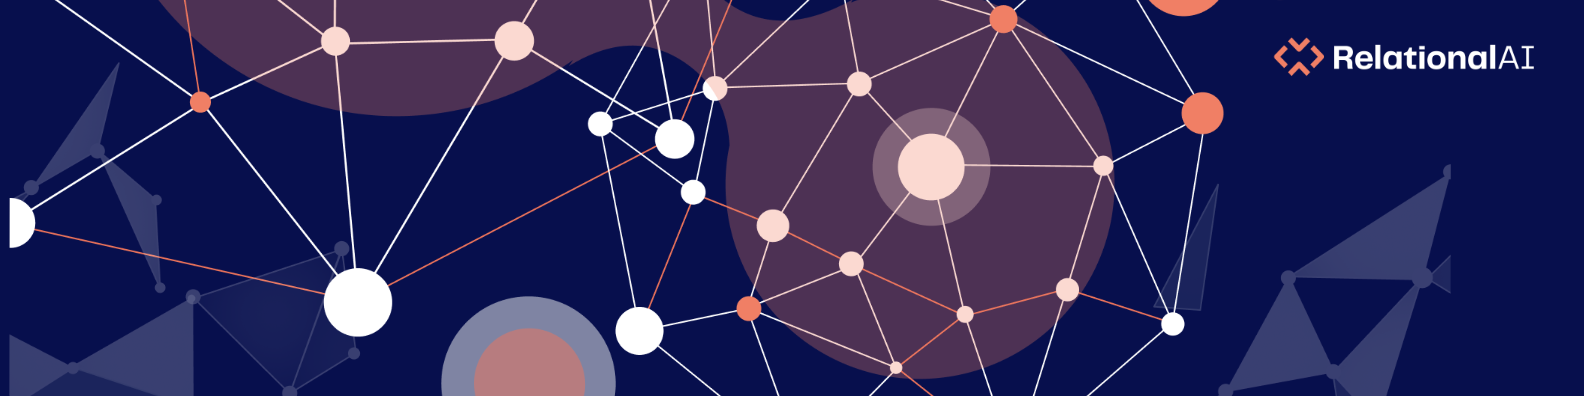

# Degree Centrality 

Degree centrality is a measure in network analysis that quantifies the importance of a node within a network based on the number of connections it has. One practical example where degree centrality can be used is in social network analysis, particularly in identifying influential individuals within a social network.

In this notebook, we will calculate the degree centrality of nodes in a small example social graph. Our graph will model a social network in which people can follow other people.

First, we need to import the `relationalai` library and define our model, which we call `DegreeCentrality`. In our model we create a type called `Person`.

In [ ]:
%pip install relationalai

In [2]:
import relationalai as rai
from relationalai.std.graphs import Graph
from relationalai.std import aggregates
import math
import colorsys

model = rai.Model("DegreeCentrality")
Person = model.Type("Person")

## Let's add some data to our model
Let's create a simple social network graph representing the follow relationship between individuals. Using a RelationalAI **rule**, we're going to populate the model with the data from our `following` list. `Person.add` adds a new object of the `Person` type to the model, setting a `name` property. We also add a `follows` link between every pair of people in the `following` list.

In [3]:
following = {
    "SarahSmith": ["JamesJohnson", "EmilyBrown", "OliviaWhite"],
    "JamesJohnson": ["SarahSmith", "EmilyBrown", "MichaelWilson", "SophiaMartinez"],
    "EmilyBrown": ["JamesJohnson", "MichaelWilson", "SophiaMartinez"],
    "DavidClark": ["MichaelWilson", "SophiaMartinez"],
    "MichaelWilson": ["JamesJohnson", "DavidClark", "SophiaMartinez", "JessicaTaylor"],
    "SophiaMartinez": ["JamesJohnson", "EmilyBrown", "MichaelWilson", "DavidClark", "JessicaTaylor"],
    "JessicaTaylor": ["EmilyBrown", "MichaelWilson", "SophiaMartinez", "OliviaWhite"],
    "OliviaWhite": ["SarahSmith"],
}

with model.rule(dynamic = True):
    for (person_name, follows) in following.items():
        person = Person.add(name = person_name)
        for other_name in follows:
            person.follows.add(Person.add(name = other_name))

## Creating the Graph
Next, we are going to create a graph for our model. Note that a model can have as many types as we want, and we need to specify which one of those are reflected in the nodes of the graph. In our case we will add all `Person` instances as nodes, and assign the name of the person to `label` property so that we can visualize it later in the graph. We then add the `follows` property as edges so that it is used to identify the relationship between two nodes in the graph when we run the algorithm.

In [4]:
# Create a directed graph
graph = Graph(model, undirected = False)
Node, Edge = graph.Node, graph.Edge

# add all Person instances as Nodes, assign `name` property (for displaying)
Node.extend(Person, label = Person.name)

# add all `follows` properties as Edges
Edge.extend(Person.follows)

##  Running the algorithm
To compute the degree centrality of each node in the graph, we use the `degree_centrality` function of `compute` object on a graph. We define a **rule**, that runs the algorithms and then sets the degree centrality of each `Person` as a property of the node.

In [5]:
with model.rule():
    person = Person()
    person_node = Node(person)
    centrality = graph.compute.degree_centrality(person_node)
    person_node.set(centrality = centrality)

## Visualizing the results

We can visualize the graph to better understand the results. For that we can use the `visualize` function on the graph object, setting the node size and color depending on the `centrality` score we calculated.

In [6]:
def get_gradient_color(value):
    rgb = colorsys.hsv_to_rgb(1, value * 0.5, 1) # Adjust the value multiplier to control the gradient range
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

graph.visualize(three = False, style = {
    "node": {
        "color": lambda n: get_gradient_color(n['centrality']),
        "size": lambda n: math.exp(3*n['centrality']),
    },
    "edge": {
        "color": "green",
    }
}).display(inline = True)

> **Tip**. We can see that the nodes with the highest centrality scores are the ones that have the most connections in the network. These nodes are likely to be the most influential individuals in the social network.

## Querying the graph
We can also query the graph to get all the nodes and centrality scores using `graph.Node()` or `graph.Edge()` types.

In [7]:
with model.query() as select:
    person = Person()
    node = Node(person)
    response = select(person.name, node.centrality)

response

### Let's find out who has the highest score
We can add a filter to the query to get the node with the highest degree centrality score. In this case, we use the `top` function from the `aggregates` module.

In [8]:
with model.query() as select:
    person = Person()
    node = Node(person)
    aggregates.top(1, node.centrality)
    response = select(person.name, node.centrality)

response